In [162]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
import pickle
from sklearn.metrics import mean_absolute_error

In [163]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from rfpimp import permutation_importances
from sklearn.metrics import mean_squared_error

In [1]:
def rmse(predictions, targets): 
    #function to calculate rmse
    return np.sqrt(((predictions - targets) ** 2).mean())

In [205]:
def metric(rf):
    print("Traning Score")
    print(rf.score(x_train,y_train))
    print("Test Score")
    print(rf.score(x_test,y_test))
    print("MAE Train")
    train=np.rint(rf.predict(x_train))
    test=np.rint(rf.predict(x_test))
    print(mean_absolute_error(train, y_train))
    print("MAE Test")
    print(mean_absolute_error(test, y_test))

    print("MSE Train")
    print(mean_squared_error(train, y_train))
    print("MSE Test")
    print(mean_squared_error(test, y_test))
    print("RMSE Train")
    print(rmse(train,y_train))
    print("RMSE Test")
    print(rmse(test,y_test))

In [206]:
# In order to get reproducible results

# Seed value (can actually be different for each attribution step)
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

In [230]:
def load_data():
    
    def dummie_and_drop(df, name):
        # Creates a dummy variable, concatenates it and finally drops the original categorical variable.
        # In order not to have redundant variables, one of the dummy variables is dropped too
        dummies = pd.get_dummies(df[name]).rename(columns = lambda x: name + '_' + str(x))
        dummies = dummies.drop(dummies.columns[-1], axis = 1)
        df = pd.concat([df, dummies], axis = 1)
        df.drop(columns = [name], inplace=True, axis=1)

        return df
    
    def convert_to_categorical(df, categorical_variables, categories, need_pickup = True):
        """ 
        The dataframe's selected variables are converted to categorical, and each variable's categories are also specified.
        It is also specified if the "pickup community area" has to be converted into categorical or no. If it is not 
        converted into categorical it is because it's not going to be used in the model.            
        """
        
        if need_pickup:
            begin = 0
        else:
            df.drop(columns = ['pickup_community_area'], inplace = True, axis = 1)
            begin = 1
        
        for i in range(begin, len(categorical_variables)):
            df[categorical_variables[i]] = df[categorical_variables[i]].astype('category').cat.set_categories(categories[i])
        return df
    
    
    def load(name, need_pickup = False, drop_correlated = False):
    
        # This parameter has to be set to True if the "pickup_community_area" variable is needed in the model
        

        # Load needed dataset and choose the useful columns
        df = pd.read_csv(name) #'dataset_train.csv')

        x = df[['pickup_community_area' ,'temperature', 'relative_humidity', 'wind_direction', 'wind_speed', 'precipitation_cat', 
                'sky_level', 'daytype', 'Day Name', 'Month', 'Hour', 'Fare Last Month', 'Trips Last Hour',
                'Trips Last Week (Same Hour)', 'Trips 2 Weeks Ago (Same Hour)', 'Year']]
#        float32=['temperature','relative_humidity','wind_direction','wind_speed','Fare Last Month', 'Trips Last Hour',
#                'Trips Last Week (Same Hour)', 'Trips 2 Weeks Ago (Same Hour)']
#        x= x[float32]=x[float32].astype('float32')
        # Convert the categorical variables
        categorical_variables = ['pickup_community_area', 'daytype', 'sky_level', 'Day Name', 'Month','Hour', 'Year']
        categories = [[*(range(1,78))], ['U', 'W', 'A'], ['OVC', 'BKN', 'SCT', 'FEW', 'CLR', 'VV '], 
                      ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
                      [*(range(1,13))], [*(range(0, 24))], [2017, 2018, 2019]]

        
        
        x = convert_to_categorical(x, categorical_variables, categories, need_pickup = need_pickup)

        float32=['temperature','relative_humidity','wind_direction','wind_speed','Fare Last Month', 'Trips Last Hour',
                'Trips Last Week (Same Hour)', 'Trips 2 Weeks Ago (Same Hour)']
        
        x[float32]=x[float32].astype('float32')
        # Make dummy variables with the categorical ones
        if need_pickup:
            begin = 0
        else:
            begin = 1
        for i in range(begin, len(categorical_variables)):
            x = dummie_and_drop(x, name = categorical_variables[i])

        y = df['Trips'].to_numpy()

        if need_pickup == False:
            # If we don't need the pickup, it means this is Neural Network case. Therefore we have to modify Y, in order
            # to have "n_areas" outputs per input (because there are "n_areas" regressions per input)
            n_areas = 77
            y = np.reshape(y, [-1, n_areas]) # If 
        
        if drop_correlated:
            x.drop(columns = ['Trips Last Week (Same Hour)'], inplace = True, axis = 1)
            x.drop(columns = ['Trips 2 Weeks Ago (Same Hour)'], inplace = True, axis = 1)

#        x = x.to_numpy()
        
        return (x,y)   
    
# ------------------------------------- MAIN PROGRAM ------------------------

    need_pickup = True 
    drop_correlated = False
    
    
    name_train = 'dataset_train.csv'
#    name_test = 'dataset_test.csv'
    x, y = load(name_train, need_pickup, drop_correlated)
#    x_test, y_test = load(name_test, need_pickup, drop_correlated)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15,shuffle=True)
    
    return (x_train, x_test, y_train, y_test)

### Load the dataset

In [231]:
x_train, x_test, y_train, y_test=load_data()

C:\Users\Iconsense\Anaconda3\envs\abhishek\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Iconsense\Anaconda3\envs\abhishek\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


### Using Gradient Boosting Regressor for prediction

In [232]:
params = {'n_estimators': 128, 'max_depth': 5, 'min_samples_split': 2,
          'learning_rate': 0.05, 'loss': 'ls','max_features':0.5,'verbose':4}
clf1 = ensemble.GradientBoostingRegressor(**params)

In [233]:
clf1=clf1.fit(x_train, y_train)

      Iter       Train Loss   Remaining Time 
         1         243.0098           17.56m
         2         221.5619           17.54m
         3         201.6797           17.38m
         4         183.7301           17.28m
         5         167.7625           17.16m
         6         153.0562           17.15m
         7         139.8545           17.07m
         8         127.8267           16.86m
         9         116.9696           16.71m
        10         107.2628           16.49m
        11          98.2989           16.31m
        12          90.2388           16.18m
        13          83.1194           16.00m
        14          76.5160           15.82m
        15          70.5466           15.69m
        16          65.1547           15.52m
        17          60.2446           15.37m
        18          55.9438           15.23m
        19          51.8932           15.07m
        20          48.2762           14.96m
        21          45.0617           14.84m
        2

In [234]:
metric(clf1)

Traning Score
0.9586622067792455
Test Score
0.9551675567872365
MAE Train
0.984311679265485
MAE Test
0.9907577897352473
MSE Train
11.09415453106338
MSE Test
11.819260265646507
RMSE Train
3.330788875186084
RMSE Test
3.437915104485058


### Plot the learning curve

In [235]:
def plot(clf):
    test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

    for i, y_pred in enumerate(clf.staged_predict(x_test)):
        test_score[i] = clf.loss_(y_test, y_pred)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Deviance')
    plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
             label='Training Set Deviance')
    plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
             label='Test Set Deviance')
    plt.legend(loc='upper right')
    plt.xlabel('Boosting Iterations')
    plt.ylabel('Deviance')


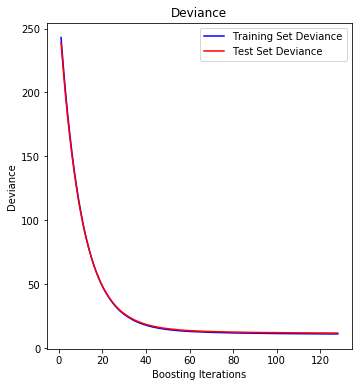

In [236]:
plot(clf1)

In [237]:
params = {'n_estimators': 256, 'max_depth': 5, 'min_samples_split': 2,
          'learning_rate': 0.05, 'loss': 'ls','max_features':0.5,'verbose':4}
clf2 = ensemble.GradientBoostingRegressor(**params)

In [238]:
clf2.fit(x_train, y_train)

      Iter       Train Loss   Remaining Time 
         1         243.1447           35.27m
         2         221.3509           34.68m
         3         201.5252           34.45m
         4         183.6861           34.29m
         5         167.5303           34.58m
         6         152.8595           34.91m
         7         139.7298           47.42m
         8         127.6901           55.04m
         9         116.9186           61.31m
        10         107.0432           65.99m
        11          98.1381           69.55m
        12          90.2070           71.55m
        13          83.0165           74.13m
        14          76.4293           76.00m
        15          70.5863           78.43m
        16          65.3344           81.41m
        17          60.4256           82.39m
        18          55.9745           83.29m
        19          51.9428           84.01m
        20          48.3168           84.14m
        21          44.9997           85.04m
        2

       183          10.5573           16.80m
       184          10.5533           16.56m
       185          10.5429           16.31m
       186          10.5366           16.07m
       187          10.5341           15.83m
       188          10.5239           15.59m
       189          10.5163           15.35m
       190          10.5065           15.11m
       191          10.5029           14.87m
       192          10.4975           14.63m
       193          10.4946           14.39m
       194          10.4895           14.16m
       195          10.4816           13.92m
       196          10.4695           13.68m
       197          10.4668           13.49m
       198          10.4592           13.33m
       199          10.4494           13.16m
       200          10.4383           13.00m
       201          10.4297           12.82m
       202          10.4259           12.67m
       203          10.4170           12.49m
       204          10.4088           12.31m
       205

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls', max_depth=5,
                          max_features=0.5, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=256,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=4, warm_start=False)

### Error increased after removing correlated columns

In [239]:
metric(clf2)

Traning Score
0.9622647154667767
Test Score
0.9577298736805407
MAE Train
0.9597832595238801
MAE Test
0.9724199574536548
MSE Train
10.132347216324687
MSE Test
11.149763134843312
RMSE Train
3.1831348096372993
RMSE Test
3.339126103465293


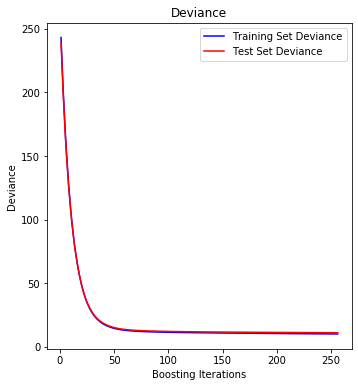

In [240]:
plot(clf2)

In [241]:
params = {'n_estimators': 256, 'max_depth': 16, 'min_samples_split': 64,'min_samples_leaf':32 ,
          'learning_rate': 0.05, 'loss': 'ls','max_features':'sqrt','verbose':4}
clf3 = ensemble.GradientBoostingRegressor(**params)

In [242]:
clf3.fit(x_train, y_train)

      Iter       Train Loss   Remaining Time 
         1         243.3742           24.12m
         2         222.1490           24.23m
         3         203.2688           23.66m
         4         185.7195           23.69m
         5         169.8801           23.85m
         6         155.2755           23.87m
         7         142.0186           23.70m
         8         130.0177           23.60m
         9         119.1858           23.53m
        10         109.6788           23.25m
        11         100.7858           23.05m
        12          92.8349           22.90m
        13          85.2446           22.79m
        14          78.5869           22.64m
        15          72.8197           22.55m
        16          67.2563           22.39m
        17          62.0807           22.30m
        18          57.5942           22.24m
        19          53.4195           22.92m
        20          49.6573           25.30m
        21          46.2820           27.34m
        2

       183           7.2148           10.06m
       184           7.2038            9.91m
       185           7.1903            9.75m
       186           7.1813            9.59m
       187           7.1716            9.44m
       188           7.1579            9.28m
       189           7.1462            9.13m
       190           7.1386            8.98m
       191           7.1272            8.83m
       192           7.1165            8.68m
       193           7.0998            8.53m
       194           7.0937            8.38m
       195           7.0845            8.23m
       196           7.0731            8.09m
       197           7.0611            7.94m
       198           7.0437            7.79m
       199           7.0320            7.65m
       200           7.0235            7.50m
       201           7.0092            7.36m
       202           7.0013            7.21m
       203           6.9935            7.07m
       204           6.9826            6.92m
       205

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls',
                          max_depth=16, max_features='sqrt',
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=32,
                          min_samples_split=64, min_weight_fraction_leaf=0.0,
                          n_estimators=256, n_iter_no_change=None,
                          presort='deprecated', random_state=None,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=4, warm_start=False)

# These metrics are best compared to all the othere

In [243]:
metric(clf3)

Traning Score
0.9757504811620707
Test Score
0.9632434753685293
MAE Train
0.8170034518722196
MAE Test
0.9069986950070613
MSE Train
6.529283498334634
MSE Test
9.699497667101664
RMSE Train
2.5552462696058544
RMSE Test
3.1144016547487356


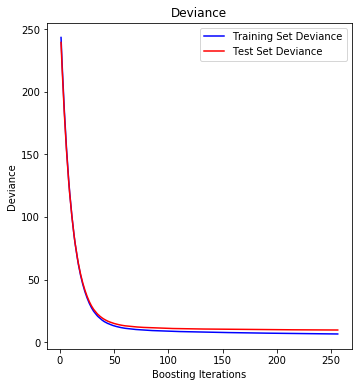

In [244]:
plot(clf3)

### This is the best model so far therefore we are saving this model

In [255]:

with open('clf3.pickle', 'wb') as f:
    pickle.dump(clf3, f)

In [245]:
params = {'n_estimators': 128, 'max_depth': 16, 'min_samples_split': 64,'min_samples_leaf':64 ,
          'learning_rate': 0.08, 'loss': 'ls','max_features':0.6,'verbose':4}
clf4 = ensemble.GradientBoostingRegressor(**params)

In [246]:
clf4=clf4.fit(x_train, y_train)

      Iter       Train Loss   Remaining Time 
         1         228.2403           62.08m
         2         195.1173           61.94m
         3         167.0202           61.23m
         4         143.2889           60.93m
         5         123.0992           60.47m
         6         106.0026           59.96m
         7          91.4618           59.54m
         8          79.1565           59.03m
         9          68.7396           58.62m
        10          59.8921           58.27m
        11          52.3604           57.74m
        12          45.9609           57.30m
        13          40.5150           56.83m
        14          35.8834           56.39m
        15          31.9460           55.93m
        16          28.5901           55.45m
        17          25.7345           54.94m
        18          23.3005           54.43m
        19          21.2202           53.91m
        20          19.4140           53.42m
        21          17.9012           52.96m
        2

In [247]:
metric(clf4)

Traning Score
0.9746973736594698
Test Score
0.9614753034817457
MAE Train
0.8157478814615344
MAE Test
0.919916337438996
MSE Train
6.811159686473342
MSE Test
10.164636479021791
RMSE Train
2.609819857092313
RMSE Test
3.1882027035654104


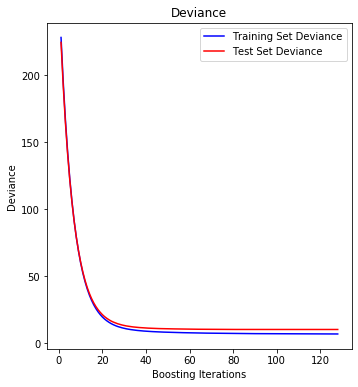

In [248]:
plot(clf4)

In [251]:
params = {'n_estimators': 256, 'max_depth': 16, 'min_samples_split': 64,'min_samples_leaf':32 ,
          'learning_rate': 0.09, 'loss': 'ls','max_features':'sqrt','verbose':4}
clf5 = ensemble.GradientBoostingRegressor(**params)

In [252]:
clf5=clf5.fit(x_train, y_train)

      Iter       Train Loss   Remaining Time 
         1         224.8771           24.60m
         2         190.2258           24.14m
         3         162.1538           23.73m
         4         137.7953           23.68m
         5         117.1870           23.20m
         6         100.2100           23.21m
         7          85.7377           23.03m
         8          73.9232           23.10m
         9          63.8577           23.03m
        10          55.5432           22.70m
        11          48.5573           22.62m
        12          42.6233           22.57m
        13          37.4038           22.49m
        14          33.0968           22.53m
        15          29.6001           22.47m
        16          26.7086           22.28m
        17          24.2372           22.10m
        18          22.1876           21.96m
        19          20.4186           21.92m
        20          18.8789           21.80m
        21          17.6059           21.74m
        2

       183           6.0103            6.84m
       184           6.0022            6.74m
       185           5.9948            6.65m
       186           5.9805            6.56m
       187           5.9676            6.47m
       188           5.9580            6.37m
       189           5.9488            6.28m
       190           5.9422            6.18m
       191           5.9315            6.09m
       192           5.9257            6.00m
       193           5.9104            5.90m
       194           5.8987            5.81m
       195           5.8865            5.72m
       196           5.8760            5.62m
       197           5.8659            5.53m
       198           5.8576            5.43m
       199           5.8490            5.34m
       200           5.8425            5.24m
       201           5.8328            5.15m
       202           5.8247            5.06m
       203           5.8150            4.96m
       204           5.8030            4.87m
       205

In [253]:
metric(clf5)

Traning Score
0.9800751459267286
Test Score
0.9641294618724328
MAE Train
0.7720231151143547
MAE Test
0.9031587979763671
MSE Train
5.373619266885687
MSE Test
9.467881084753035
RMSE Train
2.318106828186675
RMSE Test
3.076992213957168


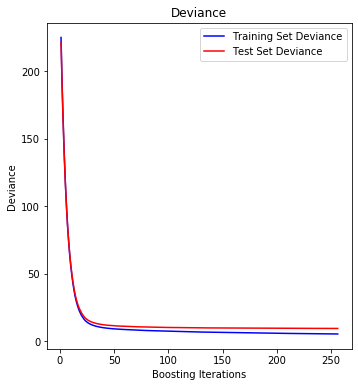

In [254]:
plot(clf5)

In [ ]:

# with open('clf3.pickle', 'rb') as f:
        
#         clf3 = pickle.load(f)